In [111]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm

from torchvision import models
from torch.nn.functional import relu

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix

from PIL import Image
import numpy as np

from torch.cuda.amp import autocast, GradScaler

In [112]:
!pip install segmentation-models-pytorch

In [113]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/augmented-forest-segmentation


In [114]:
!ls r'/kaggle/input/augmented-forest-segmentation/Forest Segmented'

ls: cannot access 'r/kaggle/input/augmented-forest-segmentation/Forest Segmented': No such file or directory


In [115]:
images_dir = r'/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images'
masks_dir  = r'/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks'

In [116]:
images_dir

'/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images'

In [117]:
image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

In [118]:
len(mask_files) == len(image_files)

True

In [119]:
train_img, val_img, train_mask, val_mask = train_test_split(image_files,
                                                            mask_files,
                                                            test_size=0.2,
                                                            random_state=42)

In [120]:
class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, images_dir, masks_dir,
                 transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_files[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  

        image = np.array(image)
        mask = np.array(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = (mask > 0.5).float()  

        mask = np.expand_dims(mask, axis=0)

        return image, mask

In [121]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

SIZE = 384

train_transform = A.Compose([
    A.RandomResizedCrop(size=(SIZE, SIZE), scale=(0.8, 1.0), ratio=(0.9, 1.1), p=1.0),
    A.Rotate(limit=45, p=0.5, border_mode=0, value=0, mask_value=0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05, p=0.8),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
    A.OneOf([
        A.MotionBlur(blur_limit=3, p=0.2),
        A.GaussianBlur(blur_limit=(3, 5), p=0.2),
        A.MedianBlur(blur_limit=3, p=0.2),
    ], p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=SIZE, width=SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


/tmp/ipykernel_114/1180213034.py:8: UserWarning: Argument(s) 'value, mask_value' are not valid for transform Rotate
  A.Rotate(limit=45, p=0.5, border_mode=0, value=0, mask_value=0),
/tmp/ipykernel_114/1180213034.py:12: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),


In [122]:
train_dataset = SegmentationDataset(train_img, train_mask, images_dir, masks_dir, train_transform)
val_dataset = SegmentationDataset(val_img, val_mask, images_dir, masks_dir, val_transform)

In [123]:
BATCH_SIZE = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [124]:
import segmentation_models_pytorch as smp

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps'
model = smp.Unet(
    encoder_name="efficientnet-b4",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None
).to(DEVICE)

print(DEVICE)

cuda


In [125]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
scaler = GradScaler()

/tmp/ipykernel_114/360466841.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [126]:
num_epochs = 20
history = {
    'train_loss': [], 'val_loss': [],
    'precision': [], 'recall': [], 'f1': [], 'pr_auc': []
}
best_pr_auc = 0.0

for epoch in tqdm(range(num_epochs)):

    model.train()
    train_loss = 0.0
    for images, masks in train_loader:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)

        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):
            logits = model(images)  
            loss = criterion(logits, masks)  

        scaler.scale(loss).backward()

        # Gradient clipping
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_dataset)
    history['train_loss'].append(train_loss)

    model.eval()
    val_loss = 0.0
    epoch_probs = []
    epoch_labels = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)

            with torch.amp.autocast('cuda'):
                logits = model(images)
                loss = criterion(logits, masks)

            val_loss += loss.item() * images.size(0)

            probs = torch.sigmoid(logits)  

            # Проверка на NaN (теперь должна возникать редко)
            if torch.isnan(probs).any():
                print(f"NaN в probs на эпохе {epoch+1}! Пропускаем батч или заменяем.")
                # Можно пропустить или обработать — но лучше понять причину
                probs = torch.nan_to_num(probs, nan=0.5)

            epoch_probs.append(probs.cpu().numpy().flatten())
            epoch_labels.append(masks.cpu().numpy().flatten())

    val_loss /= len(val_dataset)
    history['val_loss'].append(val_loss)

    try:
        probs_flat = np.concatenate(epoch_probs)
        labels_flat = np.concatenate(epoch_labels)
    except ValueError:
        # На случай, если все батчи были пропущены (маловероятно, но безопасно)
        print("⚠️ Нет валидационных данных для метрик.")
        precision = recall = f1 = pr_auc = 0.0
    else:
        # Замена оставшихся NaN (если есть)
        if np.isnan(probs_flat).any():
            print("NaN в probs_flat — заменяем на 0.5")
            probs_flat = np.nan_to_num(probs_flat, nan=0.5)

        preds_flat = (probs_flat > 0.5).astype(np.float32)

        tp = np.sum((preds_flat == 1) & (labels_flat == 1))
        fp = np.sum((preds_flat == 1) & (labels_flat == 0))
        fn = np.sum((preds_flat == 0) & (labels_flat == 1))

        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        try:
            pr_prec, pr_rec, _ = precision_recall_curve(labels_flat, probs_flat)
            pr_auc = auc(pr_rec, pr_prec)
        except:
            pr_auc = 0.0

    history['precision'].append(precision)
    history['recall'].append(recall)
    history['f1'].append(f1)
    history['pr_auc'].append(pr_auc)

    print(f"\nЭпоха {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | PR AUC: {pr_auc:.4f}")

    if pr_auc > best_pr_auc:
        best_pr_auc = pr_auc
        torch.save(model.state_dict(), 'best_unet.pth')
        print("→ Лучшая модель сохранена!")

torch.save(model.state_dict(), 'final_unet.pth')

  0%|          | 0/20 [00:00<?, ?it/s]


Эпоха 1/20
Train Loss: 0.4707 | Val Loss: 0.3984
Precision: 0.8435 | Recall: 0.8797 | F1: 0.8612 | PR AUC: 0.9189


  5%|▌         | 1/20 [03:58<1:15:34, 238.65s/it]

→ Лучшая модель сохранена!


 10%|█         | 2/20 [07:45<1:09:35, 231.97s/it]


Эпоха 2/20
Train Loss: 0.4331 | Val Loss: 0.3826
Precision: 0.8757 | Recall: 0.8387 | F1: 0.8568 | PR AUC: 0.9299
→ Лучшая модель сохранена!


 15%|█▌        | 3/20 [11:31<1:04:50, 228.85s/it]


Эпоха 3/20
Train Loss: 0.4168 | Val Loss: 0.3729
Precision: 0.8519 | Recall: 0.9018 | F1: 0.8761 | PR AUC: 0.9351
→ Лучшая модель сохранена!


 20%|██        | 4/20 [15:17<1:00:48, 228.04s/it]


Эпоха 4/20
Train Loss: 0.4034 | Val Loss: 0.3797
Precision: 0.8506 | Recall: 0.9011 | F1: 0.8751 | PR AUC: 0.9316


 25%|██▌       | 5/20 [19:00<56:32, 226.14s/it]  


Эпоха 5/20
Train Loss: 0.3951 | Val Loss: 0.3681
Precision: 0.8369 | Recall: 0.9286 | F1: 0.8804 | PR AUC: 0.9364
→ Лучшая модель сохранена!


 30%|███       | 6/20 [22:49<52:57, 226.95s/it]


Эпоха 6/20
Train Loss: 0.3852 | Val Loss: 0.3701
Precision: 0.8284 | Recall: 0.9328 | F1: 0.8775 | PR AUC: 0.9314

Эпоха 7/20
Train Loss: 0.3760 | Val Loss: 0.3508
Precision: 0.8653 | Recall: 0.8977 | F1: 0.8812 | PR AUC: 0.9401


 35%|███▌      | 7/20 [26:38<49:20, 227.76s/it]

→ Лучшая модель сохранена!


 40%|████      | 8/20 [30:26<45:32, 227.70s/it]


Эпоха 8/20
Train Loss: 0.3714 | Val Loss: 0.3615
Precision: 0.8734 | Recall: 0.8722 | F1: 0.8728 | PR AUC: 0.9391


 45%|████▌     | 9/20 [34:06<41:19, 225.42s/it]


Эпоха 9/20
Train Loss: 0.3677 | Val Loss: 0.3733
Precision: 0.8838 | Recall: 0.8471 | F1: 0.8651 | PR AUC: 0.9306


 50%|█████     | 10/20 [37:47<37:20, 224.05s/it]


Эпоха 10/20
Train Loss: 0.3604 | Val Loss: 0.3680
Precision: 0.8718 | Recall: 0.8577 | F1: 0.8647 | PR AUC: 0.9348


 55%|█████▌    | 11/20 [41:26<33:21, 222.43s/it]


Эпоха 11/20
Train Loss: 0.3496 | Val Loss: 0.3598
Precision: 0.8770 | Recall: 0.8659 | F1: 0.8714 | PR AUC: 0.9390

Эпоха 12/20
Train Loss: 0.3460 | Val Loss: 0.3412
Precision: 0.8770 | Recall: 0.8838 | F1: 0.8804 | PR AUC: 0.9448


 60%|██████    | 12/20 [45:07<29:35, 221.91s/it]

→ Лучшая модель сохранена!

Эпоха 13/20
Train Loss: 0.3441 | Val Loss: 0.3542
Precision: 0.8946 | Recall: 0.8525 | F1: 0.8731 | PR AUC: 0.9467


 65%|██████▌   | 13/20 [48:48<25:51, 221.66s/it]

→ Лучшая модель сохранена!


 70%|███████   | 14/20 [52:29<22:09, 221.63s/it]


Эпоха 14/20
Train Loss: 0.3362 | Val Loss: 0.3508
Precision: 0.8843 | Recall: 0.8665 | F1: 0.8753 | PR AUC: 0.9429

Эпоха 15/20
Train Loss: 0.3405 | Val Loss: 0.3456
Precision: 0.8879 | Recall: 0.8579 | F1: 0.8727 | PR AUC: 0.9472


 75%|███████▌  | 15/20 [56:13<18:31, 222.26s/it]

→ Лучшая модель сохранена!


 80%|████████  | 16/20 [59:55<14:49, 222.29s/it]


Эпоха 16/20
Train Loss: 0.3250 | Val Loss: 0.3644
Precision: 0.8520 | Recall: 0.9063 | F1: 0.8783 | PR AUC: 0.9342


 85%|████████▌ | 17/20 [1:03:36<11:05, 221.94s/it]


Эпоха 17/20
Train Loss: 0.3275 | Val Loss: 0.3590
Precision: 0.8707 | Recall: 0.8791 | F1: 0.8749 | PR AUC: 0.9419


 90%|█████████ | 18/20 [1:07:19<07:24, 222.11s/it]


Эпоха 18/20
Train Loss: 0.3199 | Val Loss: 0.3696
Precision: 0.8817 | Recall: 0.8517 | F1: 0.8665 | PR AUC: 0.9380


 95%|█████████▌| 19/20 [1:11:01<03:41, 221.98s/it]


Эпоха 19/20
Train Loss: 0.3189 | Val Loss: 0.3589
Precision: 0.8779 | Recall: 0.8658 | F1: 0.8718 | PR AUC: 0.9408


100%|██████████| 20/20 [1:14:44<00:00, 224.22s/it]


Эпоха 20/20
Train Loss: 0.3117 | Val Loss: 0.3611
Precision: 0.8630 | Recall: 0.8867 | F1: 0.8746 | PR AUC: 0.9394


Графики сохранены: metrics/training_plots.png


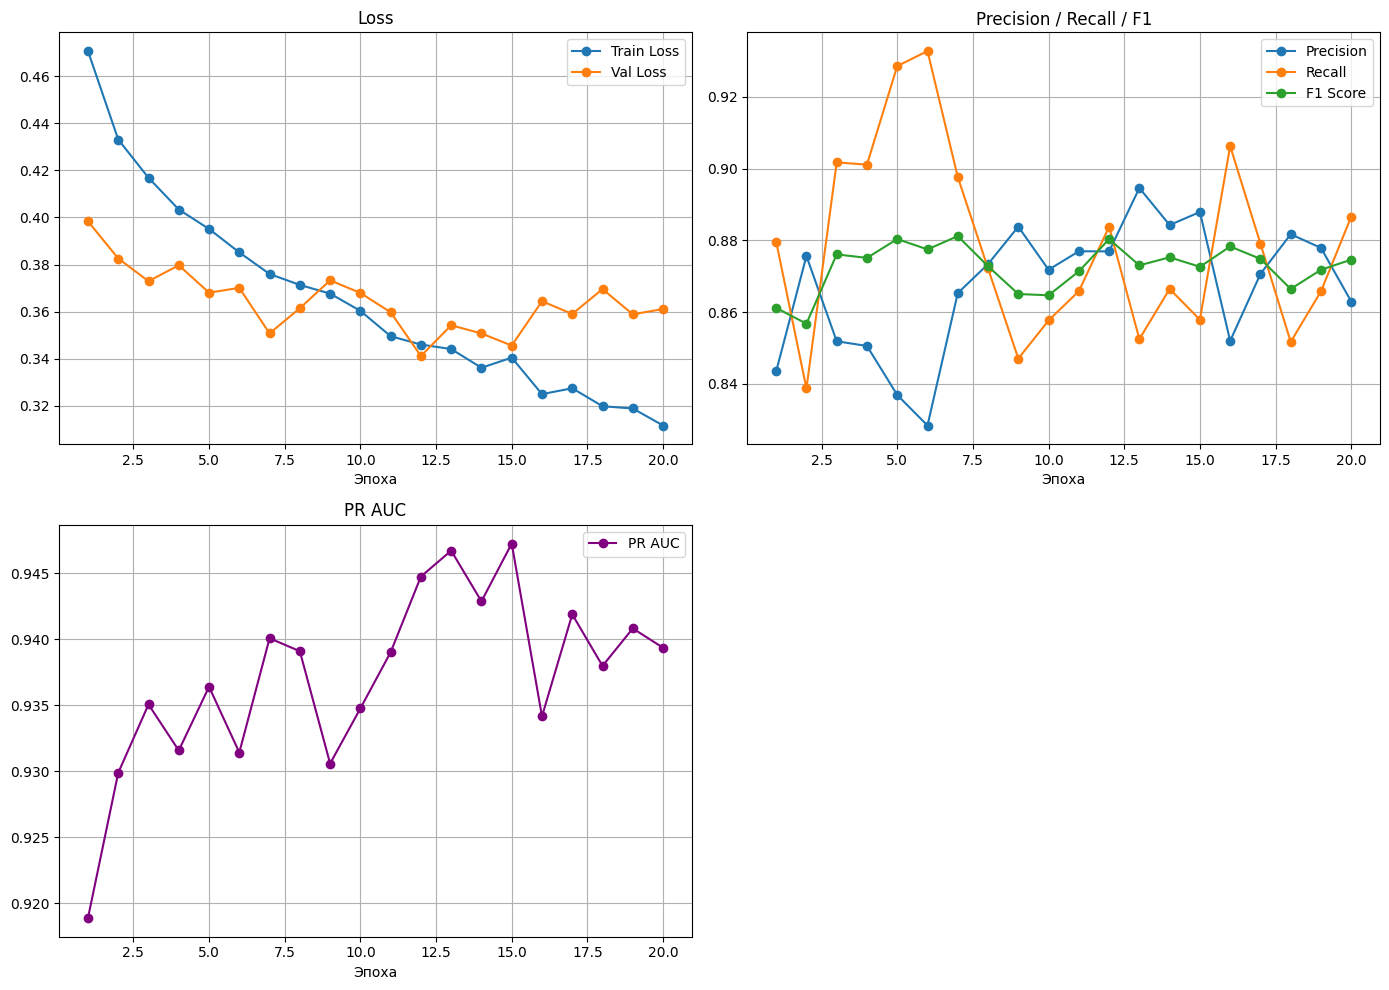


Обучение завершено! Лучший PR AUC: 0.9472


In [127]:
save_dir = 'metrics/'
os.makedirs(save_dir, exist_ok=True)

epochs = range(1, len(history['train_loss']) + 1)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axs[0, 0].plot(epochs, history['train_loss'], label='Train Loss', marker='o')
axs[0, 0].plot(epochs, history['val_loss'], label='Val Loss', marker='o')
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('Эпоха')
axs[0, 0].legend()
axs[0, 0].grid()

# Precision / Recall / F1
axs[0, 1].plot(epochs, history['precision'], label='Precision', marker='o')
axs[0, 1].plot(epochs, history['recall'], label='Recall', marker='o')
axs[0, 1].plot(epochs, history['f1'], label='F1 Score', marker='o')
axs[0, 1].set_title('Precision / Recall / F1')
axs[0, 1].set_xlabel('Эпоха')
axs[0, 1].legend()
axs[0, 1].grid()

# PR AUC
axs[1, 0].plot(epochs, history['pr_auc'], label='PR AUC', color='purple', marker='o')
axs[1, 0].set_title('PR AUC')
axs[1, 0].set_xlabel('Эпоха')
axs[1, 0].legend()
axs[1, 0].grid()

# Пустой subplot
axs[1, 1].axis('off')

plt.tight_layout()

fig_path = os.path.join(save_dir, 'training_plots.png')
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
print(f"Графики сохранены: {fig_path}")

plt.show()  

print(f"\nОбучение завершено! Лучший PR AUC: {best_pr_auc:.4f}")

In [128]:
import pandas as pd
import os

df_metrics = pd.DataFrame({
    'epoch': range(1, len(history['train_loss']) + 1),
    'train_loss': history['train_loss'],
    'val_loss': history['val_loss'],
    'precision': history['precision'],
    'recall': history['recall'],
    'f1': history['f1'],
    'pr_auc': history['pr_auc']
})

csv_path = os.path.join(save_dir, 'training_metrics.csv')
df_metrics.to_csv(csv_path, index=False)
print(f"Метрики сохранены в CSV: {csv_path}")

Метрики сохранены в CSV: metrics/training_metrics.csv


In [129]:
fp

12972287